In [1]:
#universal sentence encoder
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import numpy as np
import tqdm
            

import spacy
from nltk.corpus import stopwords 
stops = list(stopwords.words('english'))
other_stops = ['author', 'funder', 'all', 'rights', 'reuse', 'allowed' ,'also', 'use', 'without', 'permission', 'the', 'copyright', 'holder', 'for'\
                     'this', 'preprint', 'which', 'was', 'not', 'peer', 'reviewed', 'is', 'the', 'doi', 'biorxiv', 'preprint', 'author',\
                     'funder', 'all', 'reserved', 'copyright', 'holder', 'for', 'this', 'preprint', 'which', 'peer', 'reviewed', 'doi', 'biorxiv', 'preprint',
                'the copyright holder for this preprint (which was not peer-reviewed) is the . doi doi: biorxiv preprint author/funder.', \
                'all rights reserved.', ' no reuse allowed without permission.the copyright holder for this preprint (which was not peer-reviewed)', \
               'biorxiv preprint the copyright holder for this preprint (which was not peer-reviewed) is the . doi doi: biorxiv preprint significance is shown comparing the replication of c11 pk disrupt and c11 pk restore (aii).', \
               ' significance shown is compared to wt replicon. error bars are calculated by sem, n = 3, * p 673 < 0 05, **** p < 0 0001  674 author/funder.',
               'all rights reserved. no reuse allowed without permission.the copyright holder for this preprint (which was not peer-reviewed) is the . doi doi: biorxiv preprint 33 675 author/funder.',\
               ' all rights reserved. no reuse allowed without permission.the copyright holder for this preprint (which was not peer-reviewed) is the . doi doi: biorxiv preprint ']
stops = stops + other_stops


#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint

from IPython.display import Image
import re


import pickle


unable to import 'smart_open.gcs', disabling that module


### Things that can still be done
Make sure to remove non-english documents in order to reduce perplexity and to increase coherence
    
Translate non-english documents to english to increase coherence and reduce perplexity 

Run a full hyperparameter tuning script to find ideal params to maximize the results

Tie in the topics by document as output

PYLDAvis for original and optimal model

Integrate blog describing process and mathematics 

Can use Mallet instead of Gensim

# Important
This is an LDA model, therefore we can ignore elements of semantics, syntax, etc. We are utilizing Bag of Words methodologies, and therefore do not need to relate features in terms of contextual information, i.e, each document is a bag of words that can be used to inform a distribution that will be sampled.

Sampling can be done via gibbs iterative sampling, or bayes.


IMPORTANT:
CODE IS SLOW, NEED TO MOVE FROM PANDAS -> DASK

In [ ]:
print(type(stops))

### Preprocessing extended in the pattern below

In [11]:
# %%timeit 
#refer to json_to_csv.ipynb for creating the csv below
df = pd.read_csv('C:/Users/eovit/Python/Kaggle/research_pdfpapers_v2.csv')

In [ ]:
#check for missing values
missing = df.all_body.isnull().sum()

In [ ]:
#no missing values!
print(missing)

In [ ]:
#this matches our desiisnullutput from the file list len(pdf_json == 62548)
print(f'The size of our df is, {df.shape}')

In [ ]:
#below is common preprocessing, motivated by the code at: https://www.kaggle.com/matteomuffo/a-fine-grained-covid-19-question-answering-engine
def preprocessing(text):
    # remove mail  
    #we do not remove non-english words from the corpus, only non-alpha numeric characters
    text = re.sub(r'[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,}', 'MAIL', text)
    # remove doi
    text = re.sub(r'https\:\/\/doi\.org[^\s]+', 'DOI', text)
    # remove https
    text = re.sub(r'(\()?\s?http(s)?\:\/\/[^\)]+(\))?', r'\g<1>LINK\g<3>', text)
    # remove single characters repeated at least 3 times for spacing error (e.g. s u m m a r y)
    text = re.sub(r'(\w\s+){3,}', ' ', text)
    # replace tags (e.g. [3] [4] [5]) with whitespace
    text = re.sub(r'(\[\d+\]\,?\s?){3,}(\.|\,)?', r' \g<2>', text)
    # replace tags (e.g. [3, 4, 5]) with whitespace
    text = re.sub(r'\[[\d\,\s]+\]', ' ',text)
     # replace tags (e.g. (NUM1) repeated at least 3 times with whitespace
    text = re.sub(r'(\(\d+\)\s){3,}', ' ',text)
    # remove all full stops as abbreviations (e.g. i.e. cit. and so on)
    text = re.sub(r'\.(\s)?([^A-Z\s])', r' \g<1>\g<2>', text)
    # return alphanumeric information only, reduce non english language in corpus
#     text = ' '.join(t for t in text if t.isalpha())
    #return the lowered text
    return text.lower()

#secondary preprocessing incase we miss anything
#source https://tedboy.github.io/nlps/generated/generated/gensim.utils.simple_preprocess.html
def ppreprocess(data):
 
    temp = data.copy()
    temp = [re.sub(r"\'", "", x) for x in temp] #remove single quotes
    temp = [re.sub(r"\,", "", x) for x in temp] #remove commas, technically don't need to but I like too
    for sentence in temp:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [ ]:
# %%timeit 
df.all_body = df.all_body.apply(preprocessing)


In [ ]:
#lets make sure that things appear the way we want them to
#there are non-english papers in the corpus, so be careful
df.head() 

In [ ]:
df.all_body.iloc[0]

In [ ]:
#lets write out some training text for the GPT2 model
train_text = df.all_body.values.sum()

In [ ]:
file = open('C:/Users/eovit/Python/Kaggle/COVID_code/training_file_gpt520.txt', 'w', encoding= 'utf-8')
file.write(train_text)
file.close()

In [ ]:
#create a collection of all the elements in the all_body column
data = df.all_body.values.tolist()

In [ ]:
#apply secondary preprocessing (which yields a generator) and format it as a list into a manageable data structure 
#THIS IS A LIST OF LISTS REMEMBER THIS
corpus = list(ppreprocess(data))

In [ ]:
corpus[1]

In [ ]:
# Build the bigram and trigram models
# %%timeit
bigram = gensim.models.Phrases(corpus, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[corpus], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [ ]:
# See trigram example
#interesting to note that we do not see any trigrams, indicating that we did not meet the threshold, which we could perhaps lower
print(trigram_mod[bigram_mod[corpus[0]]]);

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    """
    Input: texts <collection of documents, aka corpus>
    ------------
    Output: return tokenized text that meets return criteria <gensim.utils.simple_preprocessing> and LEN(WORD) > 3
    """
    #remove words less than 3 can remove certain redundancies in the paper
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stops and len(word) > 5] for doc in texts]

def make_bigrams(texts):
    """
    Input: texts <collection of documents, aka corpus>
    ------------
    Output: tokenized bigram representation of each document
    """
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    """
    Input: texts <collection of documents, aka corpus>
    ------------
    Output: tokenized trigram representation of each document
    """
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Input: texts <collection of documents, aka corpus>
           list of POSTAGS check: https://spacy.io/api/annotation
    ------------
    Output: leammatized representation of corpus, with accompanying tagging from Spacy
    """
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [ ]:
# %%timeit
# Remove Stop Words
corpus_nostops = remove_stopwords(corpus)

# Form Bigrams
corpus_bigrams = make_bigrams(corpus_nostops)



In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en

#this part can be made much more efficient
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.max_length =  2000000
# Do lemmatization keeping only noun, adj, vb, adv
corpus_lemmatized = lemmatization(corpus_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



In [ ]:
print(corpus_lemmatized[:1]);

In [ ]:
df['lemmatized_corpus'] = corpus_lemmatized

In [ ]:
df.head()
df.to_csv('all_body_lemma_corpus.csv')

In [ ]:
#lets create the main inputs into the LDA model, which are the id2word(doc), which is dictionary of the word index adn frequency per document
#the other input to add is the corpus , which is the entire id2word(doc) collection, so it can be thought of as a nested dictionary 
# Create Dictionary
id2word = corpora.Dictionary(corpus_lemmatized)

# Create Corpus
texts = corpus_lemmatized

# Term Document Frequency
f_corpus = [id2word.doc2bow(text) for text in texts]

# View
print(f_corpus[:1]);

### Write out intermediate representation

In [ ]:
#lets write out our corpus so we can save it

pickle.dump(f_corpus, open('corpus.pkl', 'wb'))
pickle.dump(corpus_lemmatized, open('lemmatized_corpus.pkl', 'wb'))
id2word.save('dictionary528.gensim')

In [2]:
#load in the preprocessed information
#this works!
with open('corpus.pkl', 'rb') as handle:
    data = pickle.load(handle)

with open('lemmatized_corpus.pkl', 'rb') as f:
    dat = pickle.load(f)
#where d_corpus indicates downloaded
d_corpus = data
corp_text = dat
id2word1 = corpora.Dictionary.load('dictionary528.gensim')

In [ ]:
#lets check to see if the data we made and the stored files are the same
if f_corpus == d_corpus:
    print('this one works')
if corpus_lemmatized == corp_text:
    print('this one too')
if id2word == id2word:
    print('holy crud!')

### Everything after this is the actual modeling and output collection

In [5]:
#as you can see, we get the same as above
print(d_corpus[:1])

[[(0, 4), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 4), (16, 26), (17, 27), (18, 1), (19, 1), (20, 2), (21, 2), (22, 4), (23, 2), (24, 1), (25, 1), (26, 3), (27, 1), (28, 2), (29, 1), (30, 3), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 3), (40, 2), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 2), (61, 1), (62, 2), (63, 1), (64, 3), (65, 1), (66, 4), (67, 1), (68, 1), (69, 1), (70, 4), (71, 1), (72, 3), (73, 2), (74, 3), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 4), (83, 3), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 11), (94, 2), (95, 9), (96, 1), (97, 12), (98, 1), (99, 2), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 2), (107, 1), (108, 2), (109, 2), (110

In [5]:
#as we can see, d_corpus is equal to f_corpus
[[(id2word1[id], freq) for id, freq in cp] for cp in d_corpus[:1]]

[[('absence', 4),
  ('absent', 1),
  ('abundantly', 1),
  ('accept', 1),
  ('accessible', 1),
  ('accord', 1),
  ('account', 2),
  ('adaptive', 2),
  ('addition', 1),
  ('affect', 1),
  ('afterwards', 1),
  ('allow', 1),
  ('almost', 1),
  ('already', 1),
  ('analysis', 1),
  ('analyze', 4),
  ('antibody', 26),
  ('antigen', 27),
  ('apoptosis', 1),
  ('become', 1),
  ('belong', 2),
  ('bind', 2),
  ('biotinylate', 4),
  ('block', 2),
  ('buckinghamshire', 1),
  ('calprotectin', 1),
  ('capable', 3),
  ('capping', 1),
  ('cause', 2),
  ('cavity', 1),
  ('cellular', 3),
  ('centrifugation', 1),
  ('centrifuge', 1),
  ('characterize', 1),
  ('chronic', 2),
  ('classical', 1),
  ('clear', 1),
  ('clinical', 1),
  ('clinician', 1),
  ('collect', 3),
  ('complement', 2),
  ('complex', 2),
  ('complicated', 1),
  ('concentration', 1),
  ('conclusion', 1),
  ('confirm', 1),
  ('conjugate', 1),
  ('consequence', 1),
  ('consequently', 1),
  ('consistent', 1),
  ('contain', 2),
  ('continue', 1

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in f_corpus[:1]]

In [ ]:
Image(filename = "C:/Users/eovit/Python/Kaggle/Lda.png")
#where corpus is collectino of M documents [D]
#Doc containts N words
#Z is topic selected
#solve p(wN | Zn , ThetaN)

In [ ]:
# Build LDA model; can be fine tuned for coherence and perplexity, where K = num_topics, we are updating every iteration

#k is important because it
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=f_corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           workers=11, # Num. Processing Cores - 1         
                                           passes=50,
                                           eval_every= 1,
                                           #important to note that we lose access to auto-configured alpha when using multicore
                                           per_word_topics=True)

In [ ]:
#saved the model
lda_model.save('model10.gensim')

In [6]:
#lets load the model
lda_saved_mod = gensim.models.LdaModel.load('model10.gensim')

In [7]:
# lda_model = gensim.models.LdaModel.load('model15.gensim')
#from 15 to 10 topics still retained some german words, which are now in their own topics
pprint(lda_saved_mod.print_topics())
#two non-english papers
doc_lda = lda_saved_mod[d_corpus]

[(0,
  '0.017*"health" + 0.008*"public" + 0.007*"system" + 0.006*"country" + '
  '0.006*"include" + 0.006*"provide" + 0.006*"disease" + 0.005*"information" + '
  '0.005*"research" + 0.005*"people"'),
 (1,
  '0.040*"protein" + 0.012*"bind" + 0.011*"activity" + 0.010*"structure" + '
  '0.009*"domain" + 0.007*"interaction" + 0.007*"membrane" + 0.007*"peptide" + '
  '0.007*"target" + 0.007*"residue"'),
 (2,
  '0.030*"sequence" + 0.019*"sample" + 0.014*"virus" + 0.012*"genome" + '
  '0.012*"strain" + 0.009*"analysis" + 0.009*"detection" + 0.009*"detect" + '
  '0.008*"method" + 0.008*"identify"'),
 (3,
  '0.015*"number" + 0.009*"individual" + 0.009*"population" + 0.009*"result" + '
  '0.009*"model" + 0.008*"estimate" + 0.007*"figure" + 0.007*"different" + '
  '0.007*"network" + 0.006*"epidemic"'),
 (4,
  '0.009*"patient" + 0.007*"paciente" + 0.006*"wurden" + 0.005*"worden" + '
  '0.004*"wahrend" + 0.004*"infection" + 0.004*"traitement" + 0.004*"therapie" '
  '+ 0.003*"dieser" + 0.003*"allerd

In [9]:
# Compute Perplexity; lower the better
#these reSULTS ARE BETTER THAN ABSTRACT AND TITLE
#mallet is better than the LDA implementation 
#more data has given us better results (about twice as much informatoin)
print('\nPerplexity: ', lda_saved_mod.log_perplexity(d_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score, interpreted similarly to acc
coherence_model_lda = CoherenceModel(model=lda_saved_mod, texts= corp_text, dictionary=id2word1, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#when this code works get a log_perplixty of around -7.9 and Coherence of .45


Perplexity:  -7.904807565058001

Coherence Score:  0.45941070392815025


In [10]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_saved_mod, d_corpus, id2word1)
vis

c:\users\eovit\miniconda3\envs\virt\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.014581 -0.113776       1        1  15.220592
0     -0.038060 -0.158563       2        1  13.895149
1     -0.080871  0.188165       3        1  11.792665
6     -0.054947  0.105410       4        1  11.613102
8     -0.018414 -0.141029       5        1  11.364284
7     -0.083848  0.129686       6        1   9.778212
3     -0.067463 -0.071284       7        1   9.701550
2     -0.081601  0.050737       8        1   8.342007
9     -0.042549 -0.030074       9        1   7.617773
4      0.482333  0.040727      10        1   0.674676, topic_info=     Category          Freq        Term         Total  loglift  logprob
379   Default  1.058356e+06     patient  1.058356e+06  30.0000  30.0000
208   Default  6.721520e+05     protein  6.721520e+05  29.0000  29.0000
124   Default  7.443580e+05   infection  7.443580e+05  28.0000  28.0000
694   Default  2.867010e+05    sequence  2.867010e+05  27.0000  27.0000
16    Default  2.517270e+05    antibody  2.517270e+05  26.0000  26.0000
...       ...           ...         ...           ...      ...      ...
1548  Topic10  1.309108e+03   situation  3.955217e+04   1.5904  -6.1605
529   Topic10  1.354920e+03  diagnostic  6.851073e+04   1.0754  -6.1261
196   Topic10  1.314800e+03    possible  1.223551e+05   0.4655  -6.1561
333   Topic10  1.316259e+03      factor  2.394139e+05  -0.2047  -6.1550
259   Topic10  1.125855e+03   technique  7.260898e+04   0.8321  -6.3113

[942 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1771       1  0.853266  abdominal
1771       5  0.044454  abdominal
1771       6  0.002985  abdominal
1771       9  0.094815  abdominal
1771      10  0.004478  abdominal
...      ...       ...        ...
12211      2  0.046394   wildlife
12211      8  0.027290   wildlife
12211      9  0.926195   wildlife
8006      10  0.999638     worden
8007      10  0.999867     wurden

[3205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 2, 7, 9, 8, 4, 3, 10, 5])

## Assign the topics to each document


In [8]:
#we are using the best model from our coherence test
topics = lda_saved_mod.get_document_topics(d_corpus, per_word_topics=True) 

all_topics = [(doc_topics, word_topics, word_phis) for doc_topics, word_topics, word_phis in topics]

In [9]:
all_doc_tops = []
for i in range(len(all_topics)):
    all_doc_tops.append(all_topics[i][0])

In [10]:
doc_topics, word_topics, phi_values = all_topics[2]
print('Document topic:', doc_topics, "\n")
print('Word topic:', word_topics, "\n")
print('Phi value:', phi_values)

Document topic: [(3, 0.015272126), (5, 0.24788064), (6, 0.4771922), (7, 0.08920229), (8, 0.16335016)] 

Word topic: [(6, [8, 6, 5, 3, 7]), (8, [6, 8, 5, 7, 3, 2]), (14, [5, 6, 7, 8, 3, 2]), (16, [7, 6, 8, 5]), (28, [6, 8, 5, 7]), (31, [7]), (33, [6, 5, 8, 7]), (37, [5, 8, 6, 7, 2]), (39, [5, 8, 7, 2, 3]), (41, [6, 5, 3, 8]), (43, [7, 6, 5, 2]), (45, [8, 5, 7, 6, 3, 2]), (52, [6, 5, 7, 8, 3]), (53, [6, 7, 8, 5, 3]), (63, [6, 5, 7]), (65, [6, 5, 7]), (66, [8, 7, 5, 6, 2]), (69, [8, 5, 7, 2, 3]), (71, [6, 5, 8, 7, 3, 2]), (73, [5, 6, 7, 8, 3, 2]), (74, [6, 5, 7, 8, 3, 2]), (76, [6, 8, 5, 3, 7, 2]), (80, [6, 5, 7, 8, 3]), (93, [6, 7, 5]), (95, [6, 7]), (102, [7, 5, 2]), (108, [5, 6, 8, 7, 3]), (110, [6, 8, 5, 7, 3]), (111, [6, 7, 8]), (112, [5, 7, 8, 6, 3]), (113, [6, 7, 8]), (114, [6, 8, 7]), (116, [6, 8, 5]), (117, [6, 8, 5, 7]), (118, [6, 5, 8, 7, 3]), (121, [6, 7, 5, 8]), (122, [7, 6, 8, 3]), (124, [8, 6, 7, 5, 3]), (125, [8, 7, 6, 3, 5, 2]), (132, [6, 5, 7, 8, 3, 2]), (139, [6, 8, 5, 

In [12]:
df['topics_by_doc'] = all_doc_tops

In [14]:
df.to_csv('topics_by_doc1.csv', index = False)

### Lets do this the fancy way

In [17]:
def format_topics_sentences(ldamodel=None, corpus=d_corpus, texts=corp_text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [18]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_saved_mod, corpus=d_corpus, texts=corp_text)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.6749,"antibody, infection, vaccine, protein, infect,...","[feline, infectious, peritonitis, chronic, dis..."
1,1,0.0,0.4391,"health, public, system, country, include, prov...","[protect, patient, population, dominant, epide..."
2,2,6.0,0.4772,"expression, response, increase, induce, infect...","[severe, respiratory, syndrome, recently, emer..."
3,3,8.0,0.6982,"infection, patient, respiratory, disease, chil...","[authority, currently, recommend, vaccinate, s..."
4,4,0.0,0.9244,"health, public, system, country, include, prov...","[singular, definition, comprehend, become, exp..."
5,5,8.0,0.4509,"infection, patient, respiratory, disease, chil...","[synthesize, deoxyuridine, become, approve, an..."
6,6,8.0,0.5126,"infection, patient, respiratory, disease, chil...","[current, global, health, crisis, worldwide, c..."
7,7,5.0,0.5984,"patient, treatment, result, clinical, increase...","[clinical, report, report, several, country, h..."
8,8,9.0,0.6192,"animal, specie, disease, concentration, increa...","[important, disease, affect, month, palmer, mu..."
9,9,1.0,0.4492,"protein, bind, activity, structure, domain, in...","[effect, membrane, inclusion, membrane, protei..."


In [19]:
df_dominant_topic.to_csv('df_dominant_topic.csv', index = False)

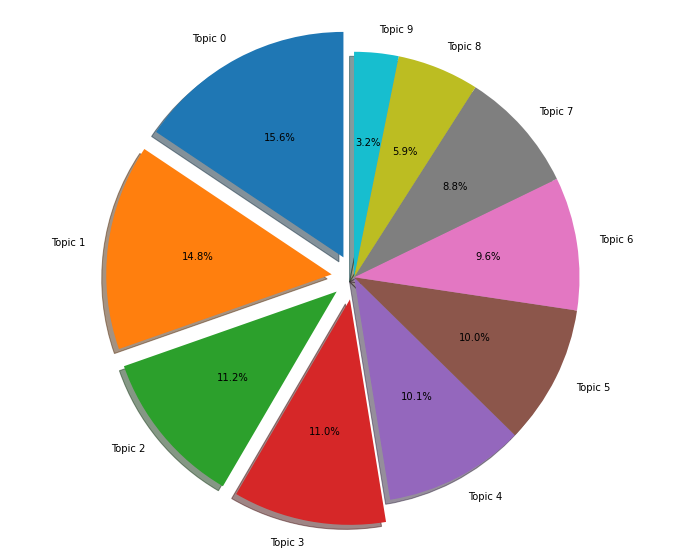

In [47]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9'

explode = (0.1, 0.1, 0.1, 0.1, 0,0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize = (12, 10))
ax1.pie(df_dominant_topic.Dominant_Topic.value_counts(), explode = explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

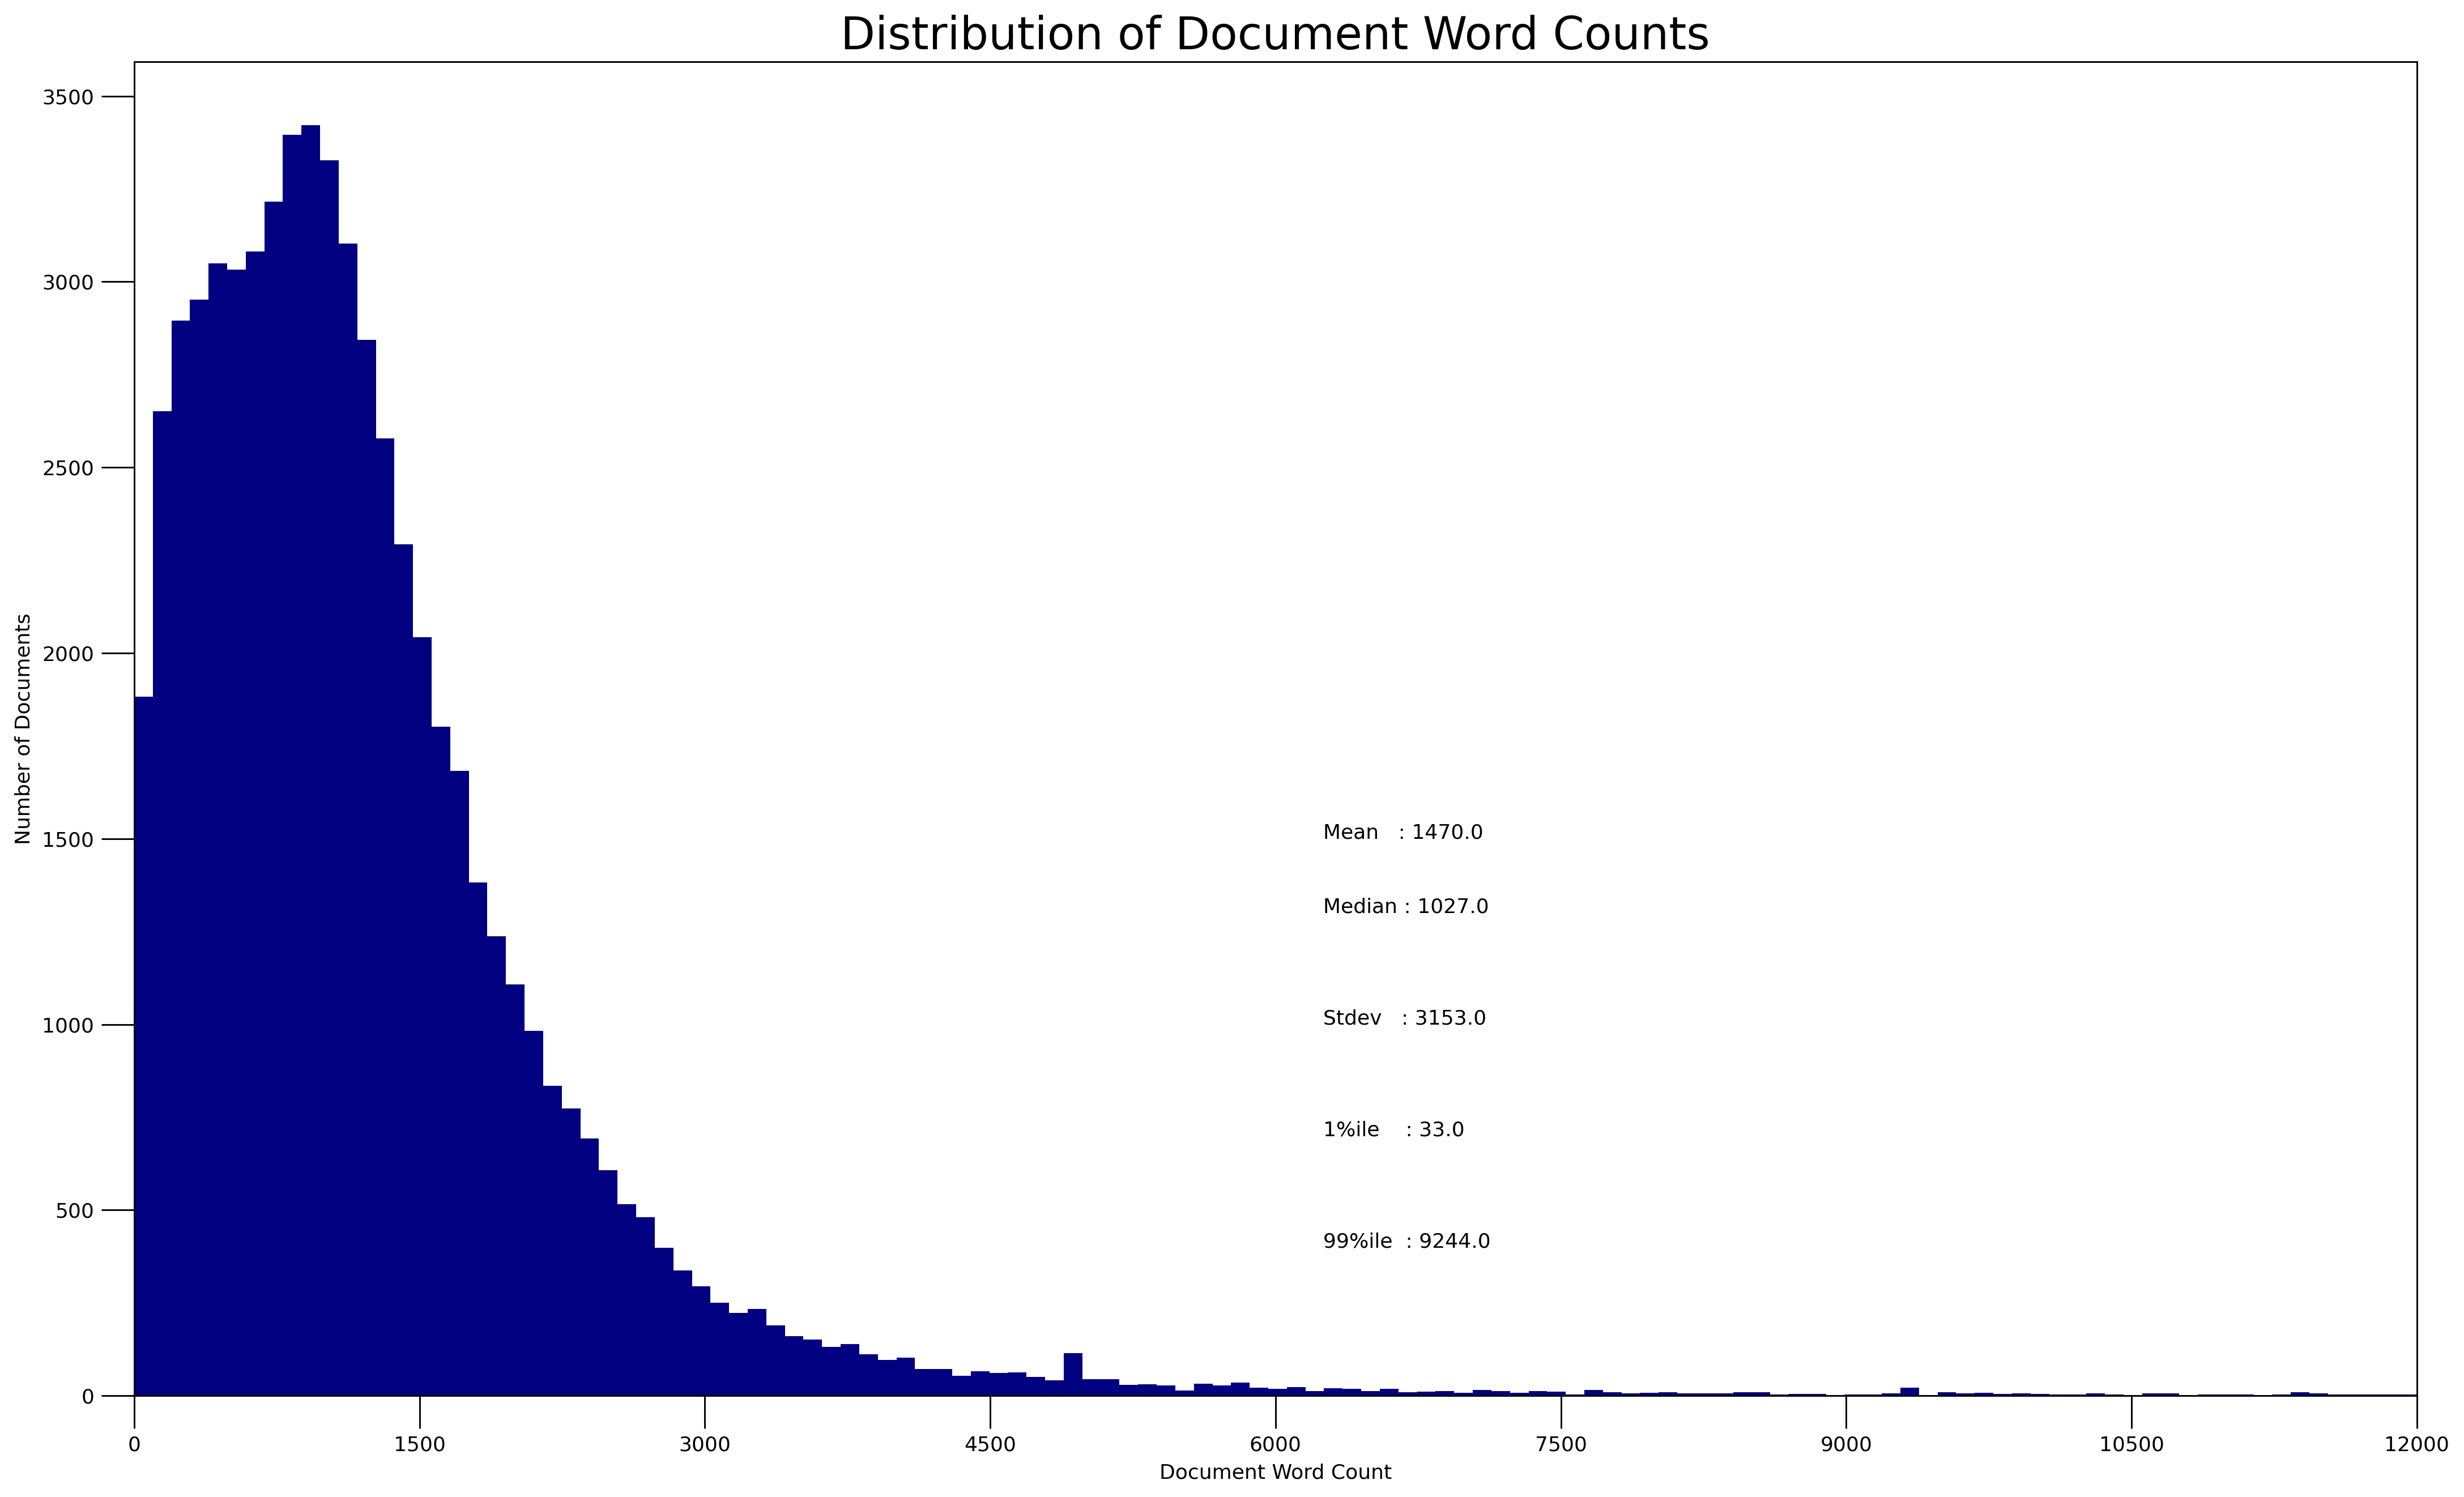

In [25]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(20,12), dpi=260)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(6250, 1500, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(6250,  1300, "Median : " + str(round(np.median(doc_lens))))
plt.text(6250,  1000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(6250,  700, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(6250,  400, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 12000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,12000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

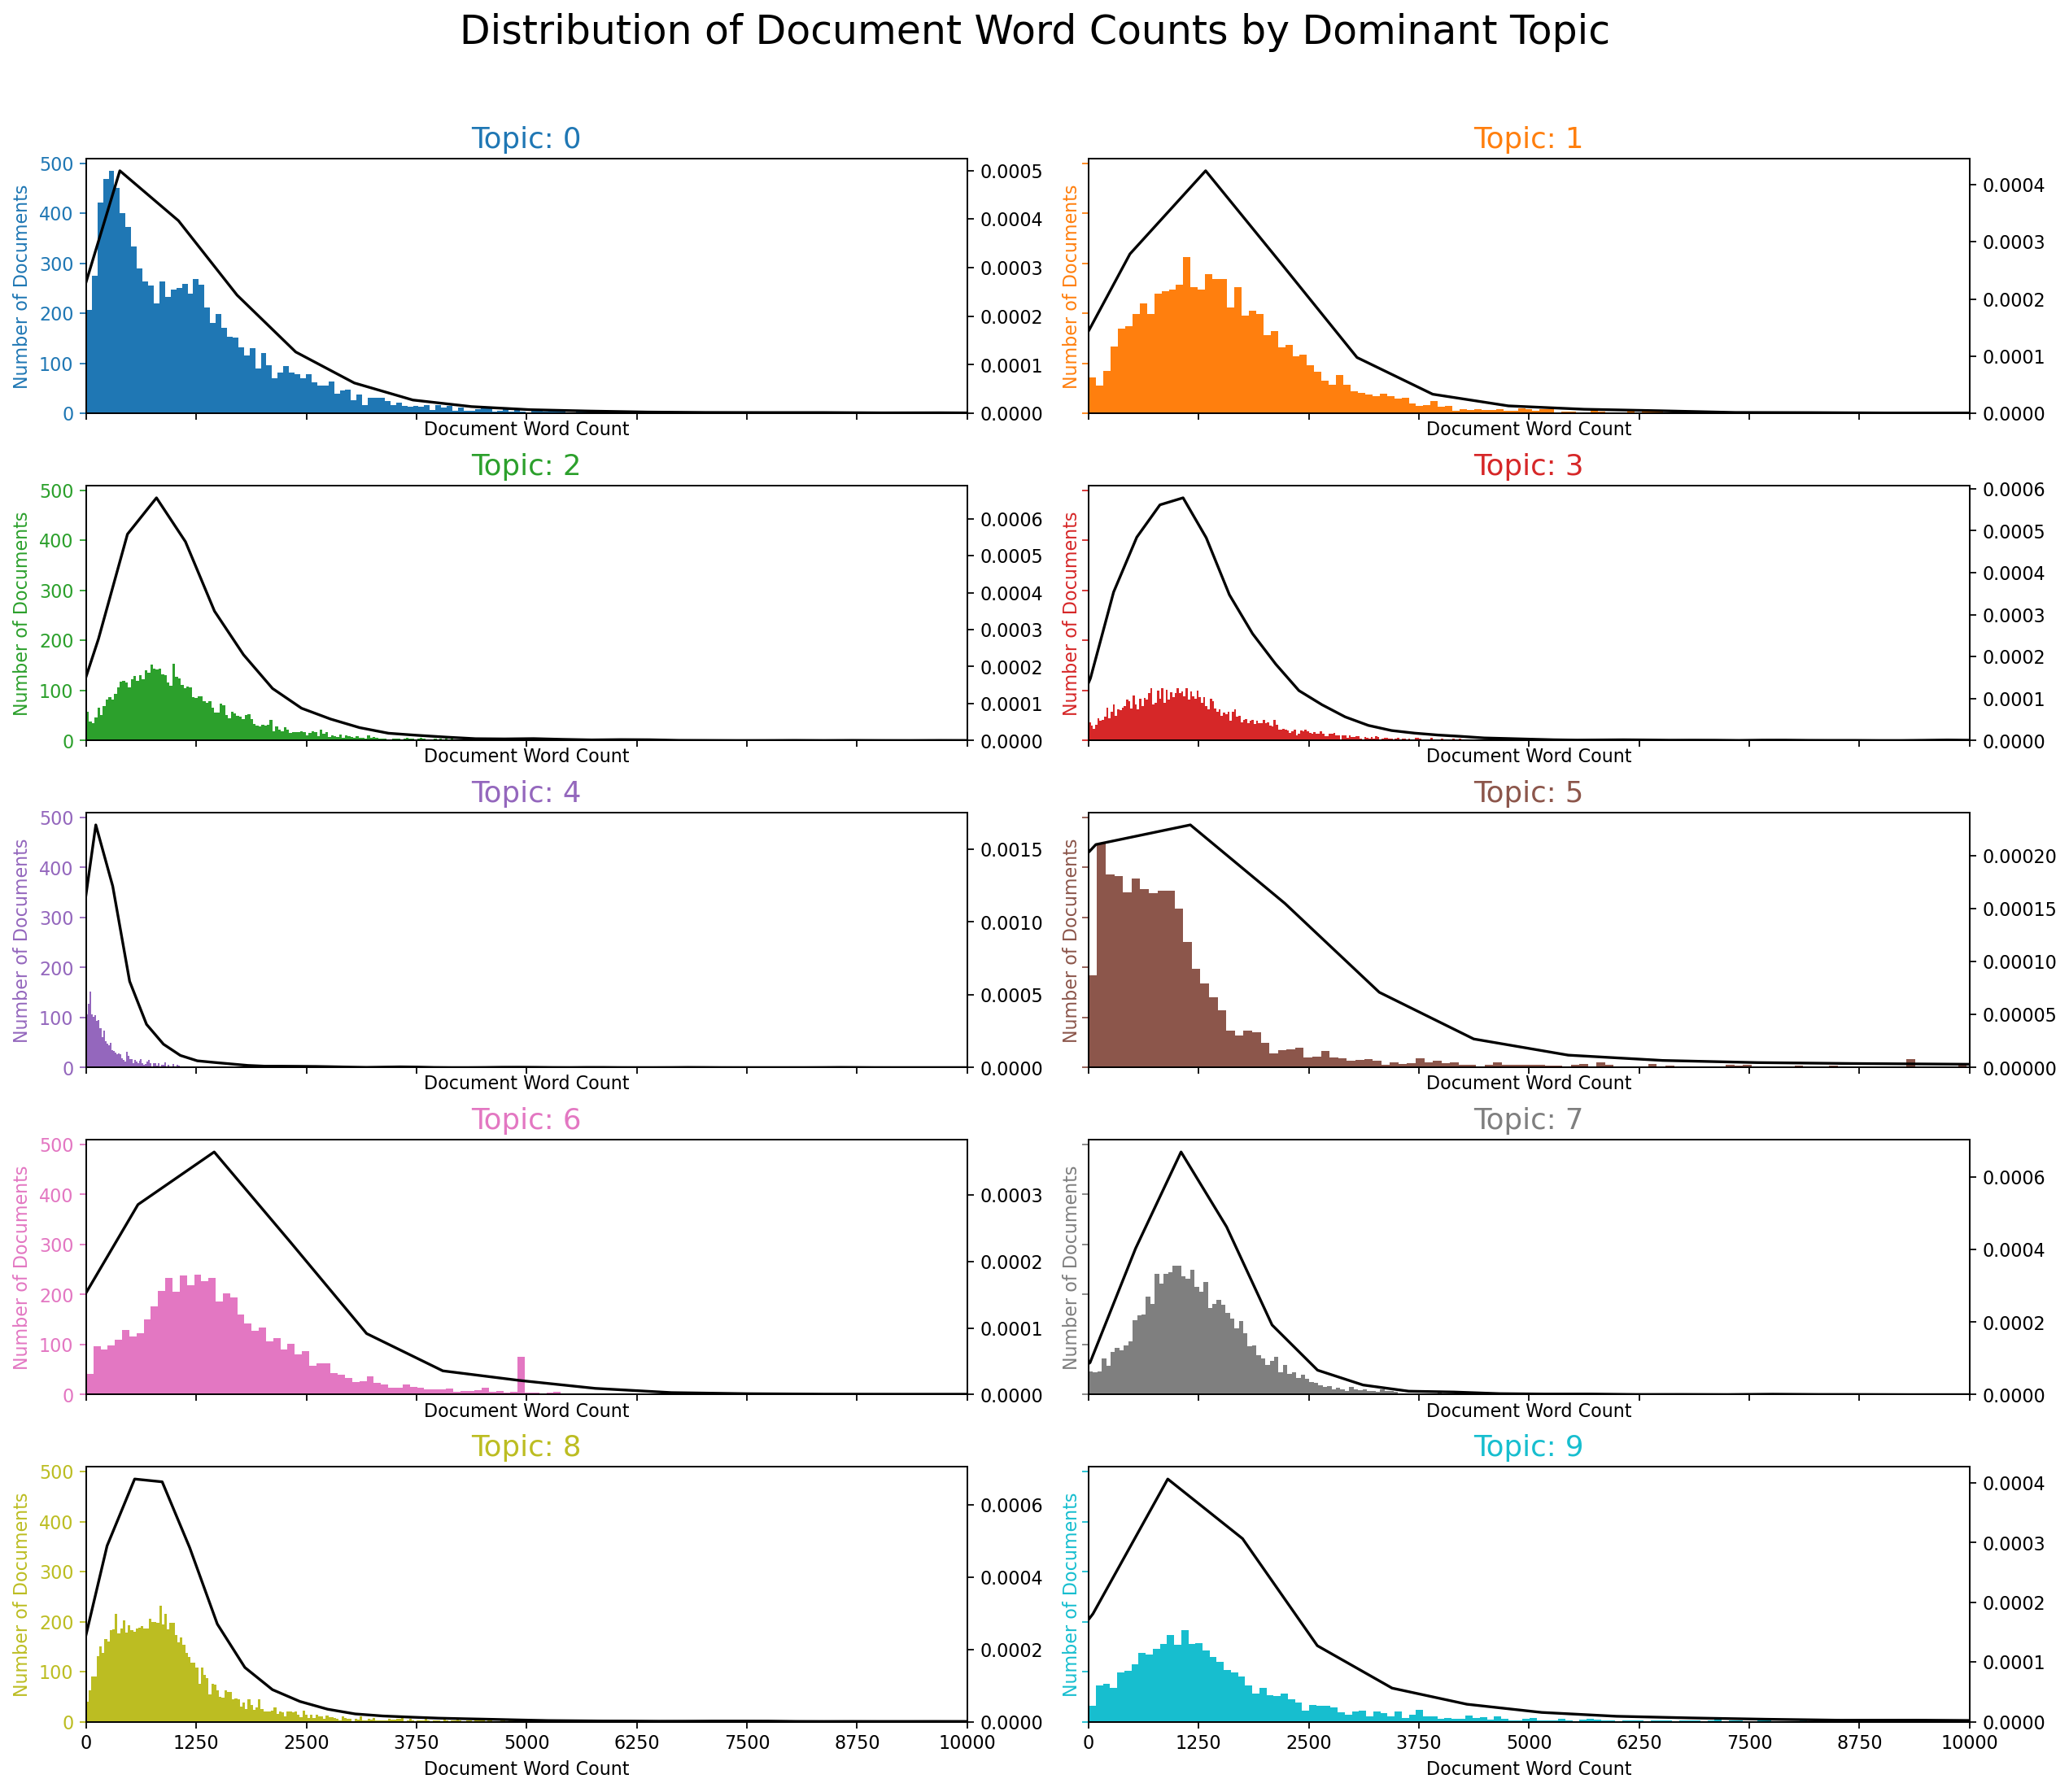

In [31]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 10000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,10000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [53]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_saved_mod[d_corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 59001 samples in 0.169s...
[t-SNE] Computed neighbors for 59001 samples in 2.176s...
[t-SNE] Computed conditional probabilities for sample 1000 / 59001
[t-SNE] Computed conditional probabilities for sample 2000 / 59001
[t-SNE] Computed conditional probabilities for sample 3000 / 59001
[t-SNE] Computed conditional probabilities for sample 4000 / 59001
[t-SNE] Computed conditional probabilities for sample 5000 / 59001
[t-SNE] Computed conditional probabilities for sample 6000 / 59001
[t-SNE] Computed conditional probabilities for sample 7000 / 59001
[t-SNE] Computed conditional probabilities for sample 8000 / 59001
[t-SNE] Computed conditional probabilities for sample 9000 / 59001
[t-SNE] Computed conditional probabilities for sample 10000 / 59001
[t-SNE] Computed conditional probabilities for sample 11000 / 59001
[t-SNE] Computed conditional probabilities for sample 12000 / 59001
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

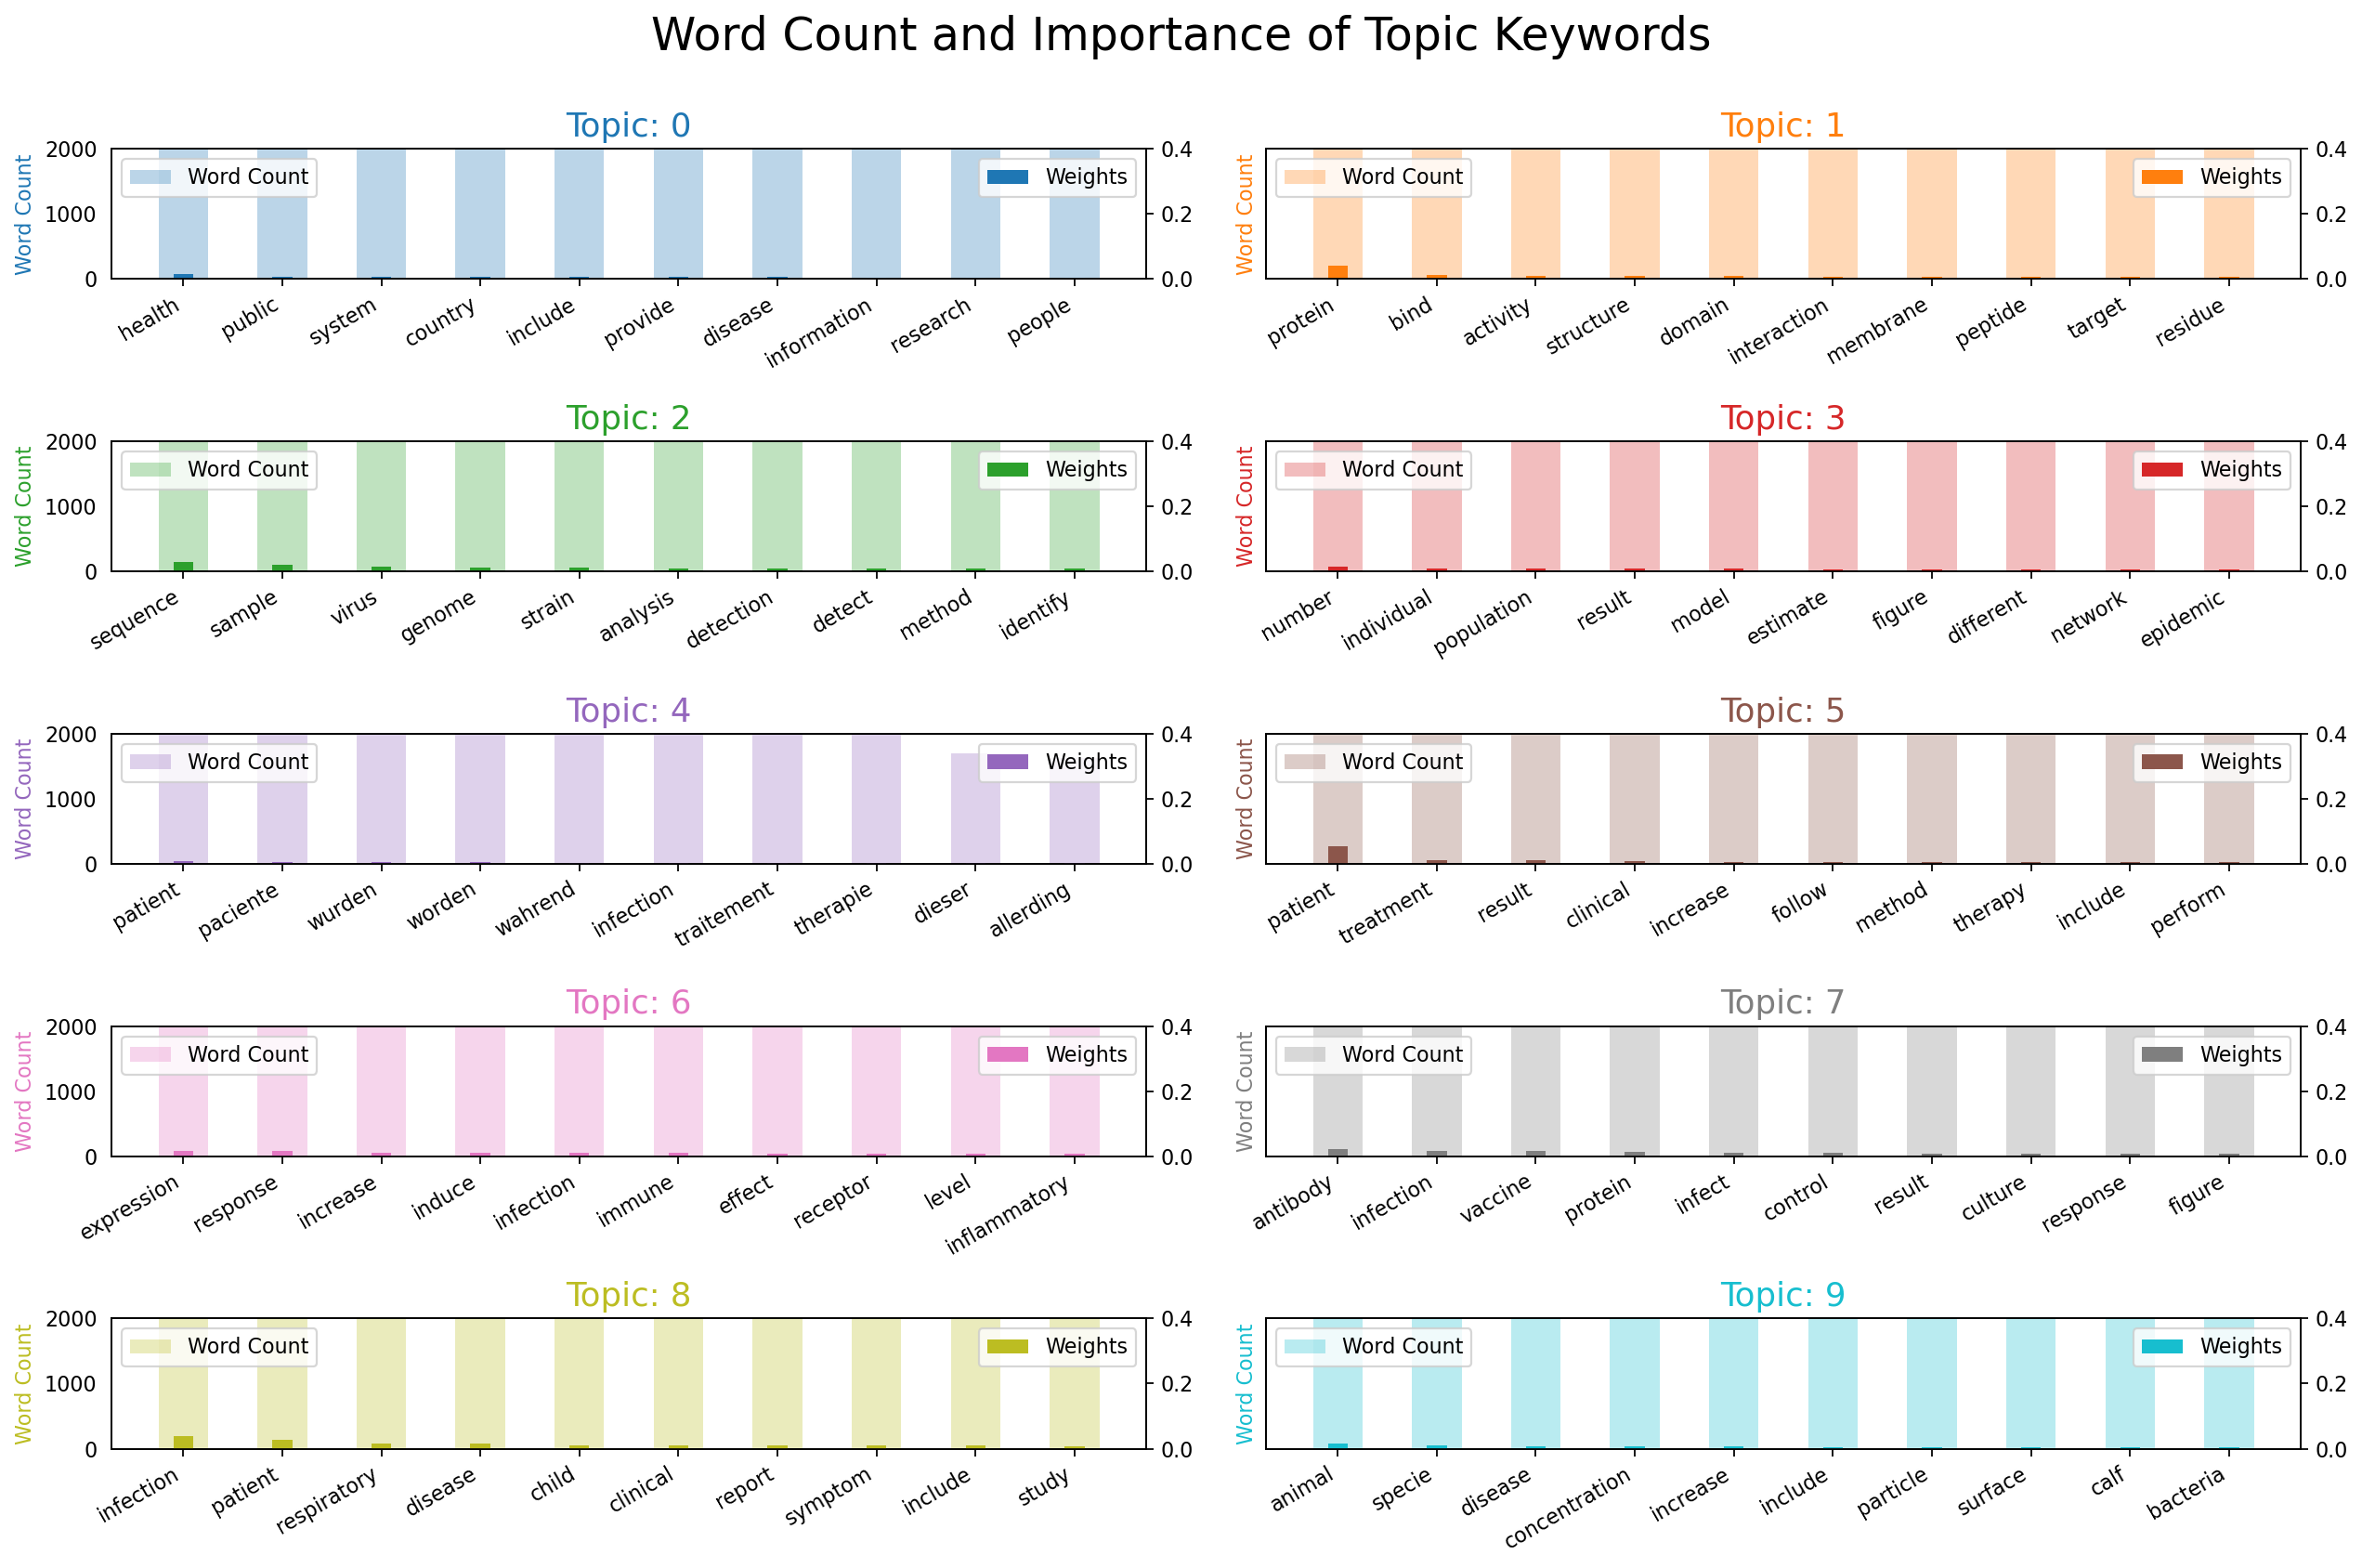

In [52]:
from collections import Counter
topics = lda_saved_mod.show_topics(formatted=False)
data_flat = [w for w_list in corp_text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.40); ax.set_ylim(0, 2000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Hyperparameter selection

In [54]:
def compute_coherence_values(corpus, dictionary, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    
    THIS DOES NOT TAKE INTO ACCOUNT ALTERATIONS TO ANY HYPERPARAMTERS OTHER THAN K

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    #changed this to a dictionary as it is easier to handle in a dataframe
    #if this does not work for some reason, use data strucutre: list
    model_res = {
        'model_list' : [],
        'coherence_values' : []
        }
    tbar = tqdm.tqdm(total = limit//2)
    for num_topics in range(start, limit, step):
        #better results, however this is about ~5 to 7x slower than Multicore
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics= num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)
            
#this version is faster, but produces worst results because we lose access to asymmetric alpha 'auto'    
    
#         model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            random_state=100,
#                                            chunksize=100,
#                                            workers=11, # Num. Processing Cores - 1         
#                                            passes=50,
#                                            eval_every= 1,
#                                            #important to note that we lose access to auto-configured alpha when using multicore
#                             

# per_word_topics=True)
        
        model_res['model_list'].append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        model_res['coherence_values'].append(coherencemodel.get_coherence())
        tbar.update(1)
    
    
    pd.DataFrame(model_res).to_csv('topic_tuning.csv', index=False)
    tbar.close()
    return model_res


# supporting function
def fine_tuned_coherence_values(corpus, dictionary, k, a, b):
    """
    Compute c_v coherence for various number of topics, alphas, and eta values
    
    THIS DOES NOT TAKE INTO ACCOUNT ALTERATIONS TO ANY HYPERPARAMTERS OTHER THAN K

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    k: number of topics passed as vector
    a = alpha (auto sets it to 1.0/num_topics)
    b = eta (auto sets: A-priori belief on word probability, can be scalar, vector, etc.)

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA 
    model with respective number of topics
    """
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           workers=11, # Num. Processing Cores - 1        
                                           passes=50,
                                           alpha=a,
                     
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=corp_text, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
results = compute_coherence_values(corpus=d_corpus, dictionary=id2word1, texts= corp_text, start=2, limit=20, step=2)


  0%|                                                                  | 0/10 [00:00<?, ?it/s]

In [ ]:
# Show graph
limit=10; start=2; step=2;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:

best_model = model_list[4]

best_coh =  coherence_values[4]

print(f'The best overall model = {best_model, best_coh}')


In [ ]:
#is our perplexity better than our manual model?
#-12.14, actually better 
print('\nBest Model Perplexity: ', best_model.log_perplexity(f_corpus))  # a measure of how good the model is. lower the better.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_model, f_corpus, id2word)
vis

Since we have strong overlap between 11 of our topics, we should probably try to play with the hyperparameters to see how this will affect the model topics output.

In [ ]:
pprint(best_model.print_topics())


In [ ]:

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 4
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter

alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
# num_of_docs = len(corpus)


model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total= 540)
    #we removed the different validation sets:
    # iterate through validation corpuses
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
             # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = fine_tuned_coherence_values(corpus=d_corpus, dictionary=id2word1, \
                                                  k=k, a=a, b=b)
                # Save the model results
                   
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                    
                pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results2.csv', index=False)
    pbar.close()


  0%|                                                                 | 0/540 [00:00<?, ?it/s]


# Assigning topics to each observation
The next step is to use the full list of papers in order to assign each paper entry (that includes the body of the paper).

This can also be done using the abstracts, as the abstract should determine some amount of information, where I = len(abstract)/len(full_paper).


In [ ]:
#inspiration https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb

#we are using the best model from our coherence test
topics = best_model.get_document_topics(f_corpus, per_word_topics=True) 

all_topics = [(doc_topics, word_topics, word_phis) for doc_topics, word_topics, word_phis in topics]

In [ ]:
all_doc_tops = []
for i in range(len(all_topics)):
    all_doc_tops.append(all_topics[i][0])

In [ ]:
#test this out for arbitrary observation in the corpus

doc_topics, word_topics, phi_values = all_topics[2]
print('Document topic:', doc_topics, "\n")
print('Word topic:', word_topics, "\n")
print('Phi value:', phi_values)

In [ ]:
df['topics_by_doc'] = all_doc_tops

In [ ]:
df

## Next steps
The next step would be to one, test out our LDA by 1) staying current with the CORD19 dataset, tuning our hyperparameters, and lasty, we could extend this code base doing something like a Author Topic model, where we can attribute topics not only by the contents of the document, but the author of the document as well.



\# Bibliography

-SPACY

-GENSIM

-https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

-https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb

-https://radimrehurek.com/gensim/models/ldamulticore.html

-https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/ 